In [1]:
import pandas as pd
import Bio
from Bio import SeqIO
from Bio.Cluster import kcluster 
import numpy as np 
import re
from sgt import SGT
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import distance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from pandas.errors import MergeError
from collections import Counter
from tslearn.clustering import KernelKMeans

# Data preprocessing
We begin with a serie of data preprocessing, first of all, we read the FASTA file with  library `Biopython` in order to create 2 mean lists, `descriptions` and `sequences`, then store them in a dataframe. In the dataframe, we firstly separate the `Description` column into several more specific columns, then extract years of every protein from `Strain Name` column, finally we sort the whole dataframe by year. Meanwhile, we should split strings of sequences into lists of letter, but also add a `id` column, those 2 columns will be useful for the following embedding operation.

In [2]:
#read the fasta file and store the data into 2 lists
with open ("H1N1_NS1_protein.fasta",'r') as H1N1_NS1_protein:
    description = []
    sequences = []
    for record in SeqIO.parse(H1N1_NS1_protein,'fasta'):
        description.append(record.description)
        sequences.append(str(record.seq))

def split(string):
    return [char for char in string]
        
#convert year in column "Strain Name" to int64
def convert_year_to_int(string):
    try: 
        year = int(string)
        if year < 1900:
            return 0
        else:
            return int(string)
    except ValueError:
        temp = re.findall(r'\d+', string)
        res = list(map(int, temp))
        if len(res) == 0:
            return 0
        else:
            return int(res[0])

# In this part of data preprocessing, we split description column into more specific columns, extract years of each sequence from strain name column, then sort the datadrame by year
df_H1N1_NS1_protein = pd.DataFrame(np.array([description], dtype = object).T, columns = ['Description'])
df_H1N1_NS1_protein[['gb', 'ncbiID', 'UniProtKB', 'Organism', 'Strain Name', 'Protein Name', 'Gene Symbol', 'Segment', 'Subtype', 'Host']] = df_H1N1_NS1_protein["Description"].str.split('|', expand = True).apply(lambda x : x.apply(lambda x : x.split(":")[1]))
df_H1N1_NS1_protein = df_H1N1_NS1_protein.drop(["Description"], axis = 1)
df_H1N1_NS1_protein["Year"] = df_H1N1_NS1_protein["Strain Name"].apply(lambda x : x.split('/')[-1]).apply(convert_year_to_int)
#sequences = [split(s) for s in sequences]
df_H1N1_NS1_protein['sequence'] = sequences
df_H1N1_NS1_protein['sequence length'] = df_H1N1_NS1_protein['sequence'].apply(lambda x : len(x))
df_H1N1_NS1_protein.drop(df_H1N1_NS1_protein.index[df_H1N1_NS1_protein['Year'] == 0], inplace = True)
df_H1N1_NS1_protein.sort_values(by = ["Year"], inplace = True, ignore_index = True)
df_H1N1_NS1_protein.reset_index(inplace=True)
df_H1N1_NS1_protein = df_H1N1_NS1_protein.rename(columns = {"index" : "id"})

# Secondly, we drop shorter sequences of each year
years = df_H1N1_NS1_protein["Year"].unique()
index = []
for y in years:
    df = df_H1N1_NS1_protein[df_H1N1_NS1_protein["Year"]==y]
    if df.shape[0] > 1:
        unique, counts = np.unique(df["sequence length"], return_counts=True)
        occurrence = dict(zip(unique, counts))
        frequent_length = max(occurrence, key=occurrence.get)
        index += df[df["sequence length"]==frequent_length].index.to_list()
    else:
        index += df.index.to_list()
df_H1N1_NS1_protein = pd.DataFrame(df_H1N1_NS1_protein, index = index)

df_H1N1_NS1_protein.head()

,id,gb,ncbiID,UniProtKB,Organism,Strain Name,Protein Name,Gene Symbol,Segment,Subtype,Host,Year,sequence,sequence length
0,0,AF333238,AAK14368.1,Q99AU3,Influenza A virus (A/Brevig Mission/1/1918(H1N1)),A/Brevig Mission/1/1918,NS1 Non-structural protein 1,NS1,8,H1N1,Human,1918,MDSNTVSSFQVDCFLWHVRKRFADQELGDAPFLDRLRRDQKSLRGR...,230
1,1,CY009608,ABD77801.1,Q20MH3,Influenza A virus (A/Wilson-Smith/1933(H1N1)),A/Wilson-Smith/1933,NS1 Non-structural protein 1,NS1,8,H1N1,Human,1933,MDPNTVSSFQVDCFLWHVRKRVADQELGDAPFLDRLRRDQKSLRGR...,230
2,2,AB981588,BAQ25795.1,A0A0C6DX30,Influenza A virus (A/NWS/1933(H1N1)),A/NWS/1933,NS1 Non-structural protein 1,NS1,8,H1N1,Human,1933,MDPNTVSSFQVDCFLWHVRKRVADQELGDSPFLDRLRRDQKSLRGR...,230
3,3,L25720,AAA91330.1,Q67249,Influenza A virus (A/NWS/1933(H1N1)),A/NWS/1933,NS1 Non-structural protein 1,NS1,8,H1N1,Human,1933,MDPNTVSSFQVDCFLWHVRKRVADQELGDSPFLDRLRRDQKSLRGR...,230
4,4,CY090849,AEG64767.1,F6GLF7,Influenza A virus (A/United Kingdom/1-MA/1933(...,A/United Kingdom/1-MA/1933,NS1 Non-structural protein 1,NS1,8,H1N1,Human,1933,MDPNTVSSFQVDCFLWHVRKRVADQELGDAPFLDRLRRDQKSLRGR...,230


Finally we select the most commun residu of each position in given year in order to create a representable sequence for each year

In [3]:
# Finally we select the most commun residu of each position in given year in order to create a representable sequence for each year
df_year = []
df_sequence = []
for y in years:
    df = df_H1N1_NS1_protein[df_H1N1_NS1_protein["Year"]==y]
    sequences = df["sequence"].to_list()
    if df.shape[0] > 1:
        sequences = np.array(df["sequence"])
        sequences = np.array([split(x) for x in sequences])
        sequence = ''
        for i in range(sequences.shape[1]):
            unique, counts = np.unique(sequences[:, i], return_counts=True)
            occurrence = dict(zip(unique, counts))
            frequent_prot = max(occurrence, key=occurrence.get)
            sequence += frequent_prot
    else:
        sequence = sequences[0]
    df_year.append(y)
    df_sequence.append(sequence)
    


# Before proceeding, we should first of all divide each sequence into 9-mer fragments
df_selected_year_sequence = pd.DataFrame(np.array([df_year], dtype = object).T, columns = ['year'])
sequences_matrix = [[sequence[i:i+9] for i in range(len(sequence)-8)] for sequence in df_sequence]
df_selected_year_sequence = pd.concat([df_selected_year_sequence, pd.DataFrame(sequences_matrix)], axis = 1)
df_selected_year_sequence.drop(columns = [222, 223, 224, 225, 226, 227, 228], inplace = True)
df_selected_year_sequence.set_index(["year"], inplace = True)
#df_selected_year_sequence = df_selected_year_sequence.T
#columns = df_selected_year_sequence.columns.tolist()
df_selected_year_sequence = df_selected_year_sequence.replace(np.nan, "", regex=True)

df_selected_year_sequence.head()

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
year,,,,,,,,,,,,,,,,,,,,,
1918,MDSNTVSSF,DSNTVSSFQ,SNTVSSFQV,NTVSSFQVD,TVSSFQVDC,VSSFQVDCF,SSFQVDCFL,SFQVDCFLW,FQVDCFLWH,QVDCFLWHV,...,PLPPKQKRK,LPPKQKRKM,PPKQKRKMA,PKQKRKMAR,KQKRKMART,QKRKMARTI,KRKMARTIK,RKMARTIKS,KMARTIKSE,MARTIKSEV
1933,MDPNTVSSF,DPNTVSSFQ,PNTVSSFQV,NTVSSFQVD,TVSSFQVDC,VSSFQVDCF,SSFQVDCFL,SFQVDCFLW,FQVDCFLWH,QVDCFLWHV,...,PLTPKQKRK,LTPKQKRKM,TPKQKRKMA,PKQKRKMAG,KQKRKMAGT,QKRKMAGTI,KRKMAGTIR,RKMAGTIRS,KMAGTIRSE,MAGTIRSEV
1934,MDPNTVSSF,DPNTVSSFQ,PNTVSSFQV,NTVSSFQVD,TVSSFQVDC,VSSFQVDCF,SSFQVDCFL,SFQVDCFLW,FQVDCFLWH,QVDCFLWHV,...,PLTPKQKRE,LTPKQKREM,TPKQKREMA,PKQKREMAG,KQKREMAGT,QKREMAGTI,KREMAGTIR,REMAGTIRS,EMAGTIRSE,MAGTIRSEV
1935,MDPNTVSSF,DPNTVSSFQ,PNTVSSFQV,NTVSSFQVD,TVSSFQVDC,VSSFQVDCF,SSFQVDCFL,SFQVDCFLW,FQVDCFLWH,QVDCFLWHV,...,PLTPKQKRK,LTPKQKRKM,TPKQKRKMA,PKQKRKMAG,KQKRKMAGT,QKRKMAGTI,KRKMAGTIR,RKMAGTIRS,KMAGTIRSE,MAGTIRSEV
1936,MDPNTVSSF,DPNTVSSFQ,PNTVSSFQV,NTVSSFQVD,TVSSFQVDC,VSSFQVDCF,SSFQVDCFL,SFQVDCFLW,FQVDCFLWH,QVDCFLWHV,...,PLTPKQKRE,LTPKQKREM,TPKQKREMA,PKQKREMAG,KQKREMAGT,QKREMAGTI,KREMAGTIR,REMAGTIRS,EMAGTIRSE,MAGTIRSEV


In [4]:
df_selected_year_sequence.shape

(62, 222)

Reshape the 2D dataframe of sequences into 1D dataframe.

In [5]:
df_sequences_in_a_column = pd.DataFrame(np.concatenate(df_selected_year_sequence.to_numpy().T), columns = ["sequence"])
df_sequences_in_a_column

,sequence
0,MDSNTVSSF
1,MDPNTVSSF
2,MDPNTVSSF
3,MDPNTVSSF
4,MDPNTVSSF
...,...
13759,
13760,
13761,
13762,


In order to simplify the embedding process, here we elimate the dublicates using `unique()`, then split 9-mers strings into lists of chararacter and add `id` column, as the `sgt` class detect `id` and `sequence` columns for embedding purpose.

In [6]:
df_unique_sequence = pd.DataFrame(columns = ["sequence"])
df_unique_sequence["sequence"] = [split(s) for s in df_sequences_in_a_column["sequence"].unique()]
df_unique_sequence.reset_index(inplace=True)
df_unique_sequence.rename(columns = {"index" : "id"}, inplace = True)
df_unique_sequence

,id,sequence
0,0,"[M, D, S, N, T, V, S, S, F]"
1,1,"[M, D, P, N, T, V, S, S, F]"
2,2,"[M, D, S, H, T, V, S, S, F]"
3,3,"[M, D, S, N, T, L, S, S, F]"
4,4,"[M, D, S, N, T, M, S, S, F]"
...,...,...
1264,1264,"[M, A, G, T, I, R, S, E, V]"
1265,1265,"[M, A, R, T, I, R, S, E, V]"
1266,1266,"[M, A, R, A, I, R, S, E, V]"
1267,1267,"[M, A, G, K, I, R, S, E, V]"


# Sequence embedding
As we can see the new dataframe only has 10% of the orginial 9-mers, now we can begin the embedding with sgt. With the embedding shape (1269, 401), we have to reduce its dimension before preceeding. 

In [7]:
#Generate the embedding of sequences
sgt = SGT(kappa = 10, lengthsensitive = False)
embedding = sgt.fit_transform(corpus=df_unique_sequence)
embedding.shape

C:\Users\Xianli.DESKTOP-II7KSPJ\anaconda3\lib\site-packages\sgt\sgt.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  for v in alphabets if v in sequence]


(1269, 401)

The traditional way of dimension reducing uses PCA a probablistic technique, which doesn't always suits well with the visualization of high-dimensional datasets, therefore, we decided to use another technique called t-sne, it looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions. 

In [8]:
"""pca = PCA(n_components=2)
pca_results = pca.fit_transform(embedding)"""
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1269 samples in 0.002s...
[t-SNE] Computed neighbors for 1269 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1269
[t-SNE] Computed conditional probabilities for sample 1269 / 1269
[t-SNE] Mean sigma: 14.105647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.469669
[t-SNE] KL divergence after 300 iterations: 0.318487


In [9]:
tsne_results

array([[-11.188486 , -21.604425 ],
       [-11.169001 , -21.582045 ],
       [-11.118736 , -21.568958 ],
       ...,
       [ 22.822529 ,  -4.9984956],
       [ 22.848495 ,  -5.017412 ],
       [ 22.872412 ,  -5.035208 ]], dtype=float32)

Once we got the 2 dimension embeddings, we combine them to their corresponding 9-mers strings. 

In [10]:
df_unique_sequence["embedding"] = list(tsne_results)
df_unique_sequence["sequence"] = df_unique_sequence["sequence"].apply(lambda x : "".join(x))
df_unique_sequence.head()

,id,sequence,embedding
0,0,MDSNTVSSF,"[-11.188486, -21.604425]"
1,1,MDPNTVSSF,"[-11.169001, -21.582045]"
2,2,MDSHTVSSF,"[-11.118736, -21.568958]"
3,3,MDSNTLSSF,"[-11.096431, -21.540504]"
4,4,MDSNTMSSF,"[-11.104297, -21.494633]"


Since we have extracted the unique values for embedding purpose, in order to reform embeddings dataframe by years and positions, firstly we have to call on `merge()` function to generate a embedding for each 9-mer in the original 9-mer dataframe `df_sequences_in_a_column`. 

In [11]:
df_sequences_in_a_column = pd.merge(df_sequences_in_a_column, df_unique_sequence, on = "sequence")
df_sequences_in_a_column.drop(columns = "id", inplace = True)
df_sequences_in_a_column.head()

,sequence,embedding
0,MDSNTVSSF,"[-11.188486, -21.604425]"
1,MDSNTVSSF,"[-11.188486, -21.604425]"
2,MDSNTVSSF,"[-11.188486, -21.604425]"
3,MDSNTVSSF,"[-11.188486, -21.604425]"
4,MDSNTVSSF,"[-11.188486, -21.604425]"


Since the purpose of this project is to encode the frequency and the position of the mutation ignoring the actual amino acid, which is quite a big challenge if we encode these two features concretely, so my method is, calculate the euclidean difference of each sequence embedding with the previous one, for the embeddings represent sequences in euclidean space, this relative distance can easily neglige the actual amino acid type, and they are stocked in `df_embedding_distance`. By this method, we have turned the problem of analyzing the pattern of amino acid residues into clustering time series. 

In [12]:
nbr_columns = int(df_sequences_in_a_column.shape[0]/len(df_year))
df_embedding = pd.DataFrame(index = df_year) 
df_embedding_distance = pd.DataFrame(index = df_year) 

for i in range(nbr_columns):
    array_9_mer_embedding = df_sequences_in_a_column["embedding"].to_numpy()[i*len(df_year):(i+1)*len(df_year)]
    distances = []
    for j in range(array_9_mer_embedding.shape[0]):
        if j == 0:
            distances.append(0)
        else:
            distances.append(distance.euclidean(array_9_mer_embedding[j-1], array_9_mer_embedding[j]))
    df_embedding_distance[i] = distances
    df_embedding[i] = array_9_mer_embedding

df_embedding.head()

C:\Users\Xianli.DESKTOP-II7KSPJ\anaconda3\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
C:\Users\Xianli.DESKTOP-II7KSPJ\anaconda3\lib\site-packages\ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
1918,"[-11.188486, -21.604425]","[-11.061187, -21.420237]","[-10.861682, -21.130383]","[-10.745667, -20.779898]","[-10.696031, -20.447807]","[-10.664487, -20.185127]","[-10.64135, -19.900352]","[-10.635132, -19.794136]","[-10.629457, -19.693634]","[-10.624712, -19.585365]",...,"[13.702138, -5.458104]","[14.812816, -4.4803247]","[16.108511, -3.7735069]","[17.158228, -3.4670134]","[18.612926, -3.399861]","[19.465073, -3.5340884]","[20.501673, -3.8315341]","[21.314537, -4.151925]","[22.023191, -4.510591]","[22.560968, -4.8214674]"
1933,"[-11.188486, -21.604425]","[-11.061187, -21.420237]","[-10.861682, -21.130383]","[-10.745667, -20.779898]","[-10.696031, -20.447807]","[-10.664487, -20.185127]","[-10.64135, -19.900352]","[-10.635132, -19.794136]","[-10.629457, -19.693634]","[-10.624712, -19.585365]",...,"[13.702138, -5.458104]","[14.812816, -4.4803247]","[16.108511, -3.7735069]","[17.158228, -3.4670134]","[18.612926, -3.399861]","[19.465073, -3.5340884]","[20.610914, -3.8696668]","[21.314537, -4.151925]","[22.023191, -4.510591]","[22.560968, -4.8214674]"
1934,"[-11.188486, -21.604425]","[-11.061187, -21.420237]","[-10.861682, -21.130383]","[-10.745667, -20.779898]","[-10.696031, -20.447807]","[-10.664487, -20.185127]","[-10.64135, -19.900352]","[-10.635132, -19.794136]","[-10.629457, -19.693634]","[-10.624712, -19.585365]",...,"[13.702138, -5.458104]","[14.812816, -4.4803247]","[16.108511, -3.7735069]","[17.28429, -3.4462743]","[18.612926, -3.399861]","[19.465073, -3.5340884]","[20.712866, -3.9087336]","[21.403767, -4.193425]","[22.023191, -4.510591]","[22.560968, -4.8214674]"
1935,"[-11.188486, -21.604425]","[-11.061187, -21.420237]","[-10.861682, -21.130383]","[-10.745667, -20.779898]","[-10.696031, -20.447807]","[-10.664487, -20.185127]","[-10.64135, -19.900352]","[-10.635132, -19.794136]","[-10.629457, -19.693634]","[-10.624712, -19.585365]",...,"[13.702138, -5.458104]","[14.812816, -4.4803247]","[16.108511, -3.7735069]","[17.398653, -3.4282625]","[18.612926, -3.399861]","[19.465073, -3.5340884]","[20.712866, -3.9087336]","[21.487911, -4.2339754]","[22.023191, -4.510591]","[22.560968, -4.8214674]"
1936,"[-11.188486, -21.604425]","[-11.061187, -21.420237]","[-10.861682, -21.130383]","[-10.745667, -20.779898]","[-10.696031, -20.447807]","[-10.664487, -20.185127]","[-10.64135, -19.900352]","[-10.635132, -19.794136]","[-10.629457, -19.693634]","[-10.624712, -19.585365]",...,"[13.702138, -5.458104]","[14.812816, -4.4803247]","[16.108511, -3.7735069]","[17.398653, -3.4282625]","[18.735891, -3.4127438]","[19.465073, -3.5340884]","[20.712866, -3.9087336]","[21.487911, -4.2339754]","[22.023191, -4.510591]","[22.560968, -4.8214674]"


In [13]:
df_embedding_distance.head()

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
1918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.115706,0.000000,0.0,0.0
1934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.127757,0.000000,0.0,0.109180,0.098408,0.0,0.0
1935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.115772,0.000000,0.0,0.000000,0.093406,0.0,0.0
1936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.123638,0.0,0.000000,0.000000,0.0,0.0


Let's take a look at each 9-mer's evolution from the figure below:

<AxesSubplot:>

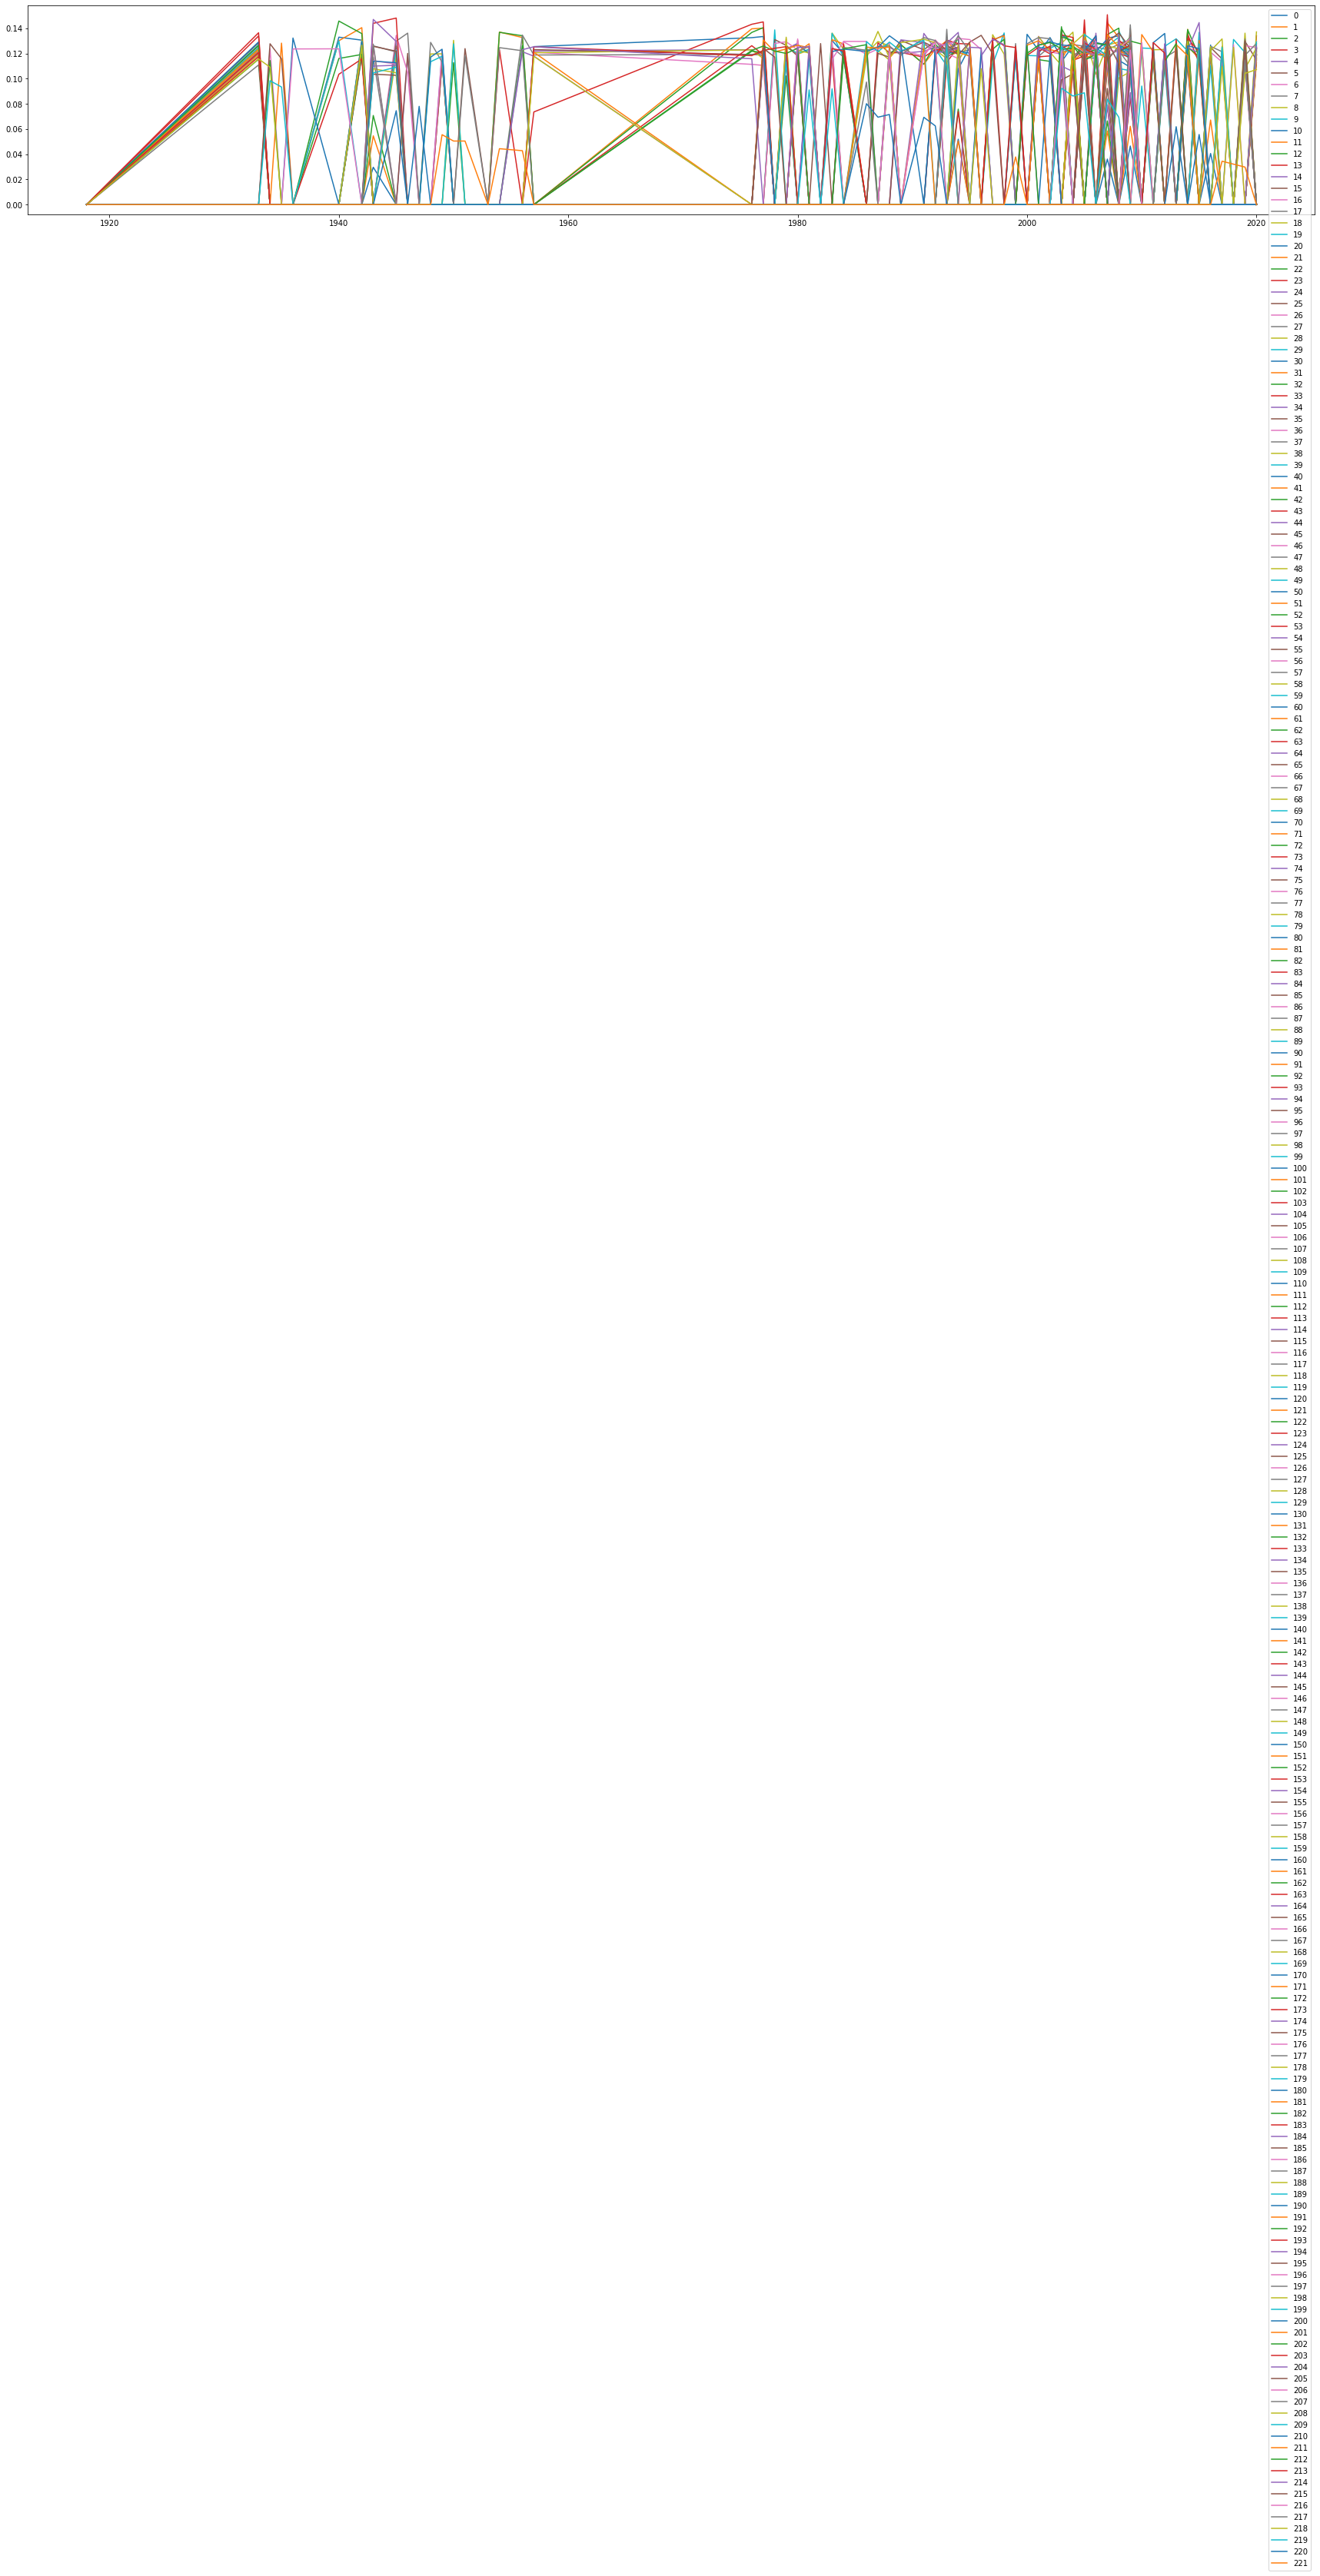

In [14]:
df_embedding_distance.plot.line(figsize=(30, 5))

# K Means clustering
Then we can run the K Means algorithm provided by `tslearn`, which generates labels of each 9-mer. In order to plot the clustering result, we have to run a t-sne algorithm so that every time series can be represented in 2 dimensional way. 

By using the package called "tslearn", which provides machine learning tools for the analysis of time series, I can run the K means approach on our data above. First of all, we should start by transform the dataframe into time series dataset.

In [15]:
time_series_dataset = to_time_series_dataset(df_embedding_distance.T)
time_series_dataset.shape

(222, 62, 1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 222 samples in 0.000s...
[t-SNE] Computed neighbors for 222 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 222 / 222
[t-SNE] Mean sigma: 0.114666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.760975
[t-SNE] KL divergence after 300 iterations: 0.782072
          0         1  label
0  1.777900 -0.127621      4
1  2.015841  0.244628      4
2  2.109223  0.900150      1
3  1.584811  1.030215      4
4  1.108506  1.673480      0


<AxesSubplot:xlabel='0', ylabel='1'>

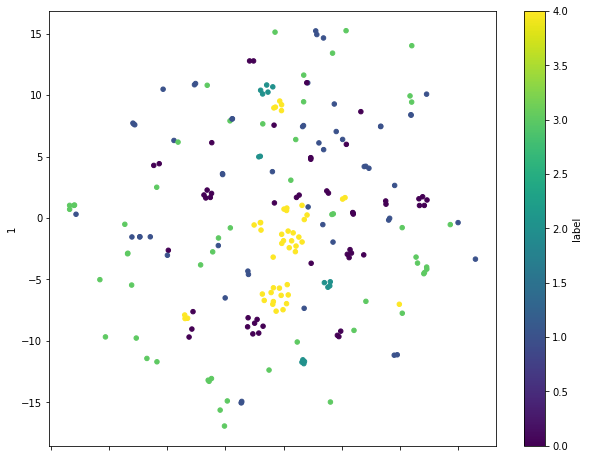

In [16]:
# run the K means clustering
num_clusters = 5
km = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", n_init = 20)
labels = km.fit_predict(time_series_dataset)
df_labels = pd.Series(labels, index = df_embedding_distance.columns.to_list())

# reduce the dimensions into 2 then show the clustering with scatter
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
df_scatter = pd.DataFrame(tsne.fit_transform(df_embedding_distance.T))
"""pca = PCA(n_components=2)
df_cluster_results = pd.DataFrame(pca.fit_transform(df_embedding_distance.T))"""
df_scatter["label"] = labels
print(df_scatter.head())
df_scatter.plot.scatter(x = 0, y = 1, c = "label", cmap='viridis', figsize=(10, 8))

In [17]:
# run the K means clustering with kernel k means
# num_clusters = 5
# km = KernelKMeans(n_clusters=num_clusters, n_init=40)
# labels = km.fit_predict(time_series_dataset)
# df_labels = pd.Series(labels, index = df_embedding_distance.columns.to_list())

# # reduce the dimensions into 2 then show the clustering with scatter
# tsne = TSNE(n_components=2, verbose=1, n_iter=300)
# df_scatter = pd.DataFrame(tsne.fit_transform(df_embedding_distance.T))
# """pca = PCA(n_components=2)
# df_cluster_results = pd.DataFrame(pca.fit_transform(df_embedding_distance.T))"""
# df_scatter["label"] = labels
# print(df_scatter.head())
# df_scatter.plot.scatter(x = 0, y = 1, c = "label", cmap='viridis', figsize=(10, 8))

# Evaluation of the clustering
Now we have finally finished the clustering, the next stape is to evaluate the result, by sampling random sequences each 10 years, then predict their epitopes for HLA-A02:01 using `NetMHCpan`, plot these epitopes to see if they belong to any clusters. 

In [18]:
years_samples = [years[y] for y in range(0, years.shape[0], 10)]
for s in years_samples:
    print("The gb of the year of " + str(s) + " is : " + str(df_H1N1_NS1_protein[df_H1N1_NS1_protein["Year"]==s]["gb"].iloc[0]))

The gb of the year of 1918 is : AF333238
The gb of the year of 1947 is : CY087788
The gb of the year of 1977 is : CY010376
The gb of the year of 1988 is : CY024929
The gb of the year of 1999 is : DQ508861
The gb of the year of 2009 is : CY064752
The gb of the year of 2019 is : MK839470


In [19]:
weak_binders = {
    1918 : ["QVDCFLWHV", "TLGLDIETA", "ILKEESDEA", "MLMPKQKVA", "AIVGEISPL"],
    1947 : ["QVDCFLWHV", "TLGLNIETA", "ILKEESDEA", "MLMPKQKVA", "AIVGEISPL"], 
    1977 : ["QVDCFLWHV", "TLGLNIETA", "ILKEESDEA", "MLMPKQKVA", "AIVGEISPL"], 
    1988 : ["TLGLNIETA", "TLKMNIASV", "FMLMPRQKI", "AIVGEISPL"], 
    1999 : ["TLGLNIETA", "TLKMNIASV", "FMLMPRQKI", "AIVGEISPL"], 
    2009 : ["TLGLDIETA", "TLRMTIASV", "FMLMPRQKI", "MLMPRQKII", "IIGPLCVRL", "IVLKANFSV", "AIVGEISPL"],
    2019 : ["TLGLDIKTA", "TLRMAIASV", "FMLMPRQKI", "MLMPRQKII", "IIGPLCVRL", "TIVGEISPL"]
}
strong_binders = {
    1918 : ["ALKMTIASV", "FMLMPKQKV", "AIMDKNIIL", "IILKANFSV", "VIFDRLETL"], 
    1947 : ["FLWHVRKRV", "FMLMPKQKV", "AIMDKSIIL", "IILKANFSV", "VIFDRLETL"], 
    1977 : ["FLWHVRKQV", "FMLMPKQKV", "AIMDKNIIL", "IILKANFSV", "VIFDRLETL"], 
    1988 : ["GLNIETATL", "AIMEKNIIL", "IILKANFSV", "VIFNRLETL", "IVGEISPLL"], 
    1999 : ["GLNIETATL", "AIMEKNIIL", "IILKANFSV", "VIFNRLETL", "IVGEISPLL"], 
    2009 : ["GLDIETATL", "AIMEKNIVL", "VIFNRLETL"], 
    2019 : ["GLDIKTATL", "AVMDKNIVL", "IVLEANFSV", "VIFNRLETL"]
}

In favor of showing binders on the same graph as time series, in the first place we should generate their "coordinates" in their dataframe, which is their corresponding years and columns. To do so, 

In [20]:
weak_binders_mask = {}
strong_binders_mask = {}
for y in years_samples:
    weak_binders_mask[y] = df_selected_year_sequence.loc[y].isin(weak_binders[y])
    strong_binders_mask[y] = df_selected_year_sequence.loc[y].isin(strong_binders[y])


Cluster 0 has 4 weak binders within 62 9-mers.

Cluster 0 has 12 strong binders within 62 9-mers.

Cluster 1 has 17 weak binders within 62 9-mers.

Cluster 1 has 6 strong binders within 62 9-mers.

Cluster 2 doesn't have any weak binder within 62 9-mers.

Cluster 2 doesn't have any strong binder within 62 9-mers.

Cluster 3 has 2 weak binders within 62 9-mers.

Cluster 3 has 8 strong binders within 62 9-mers.

Cluster 4 has 9 weak binders within 62 9-mers.

Cluster 4 has 1 strong binders within 62 9-mers.


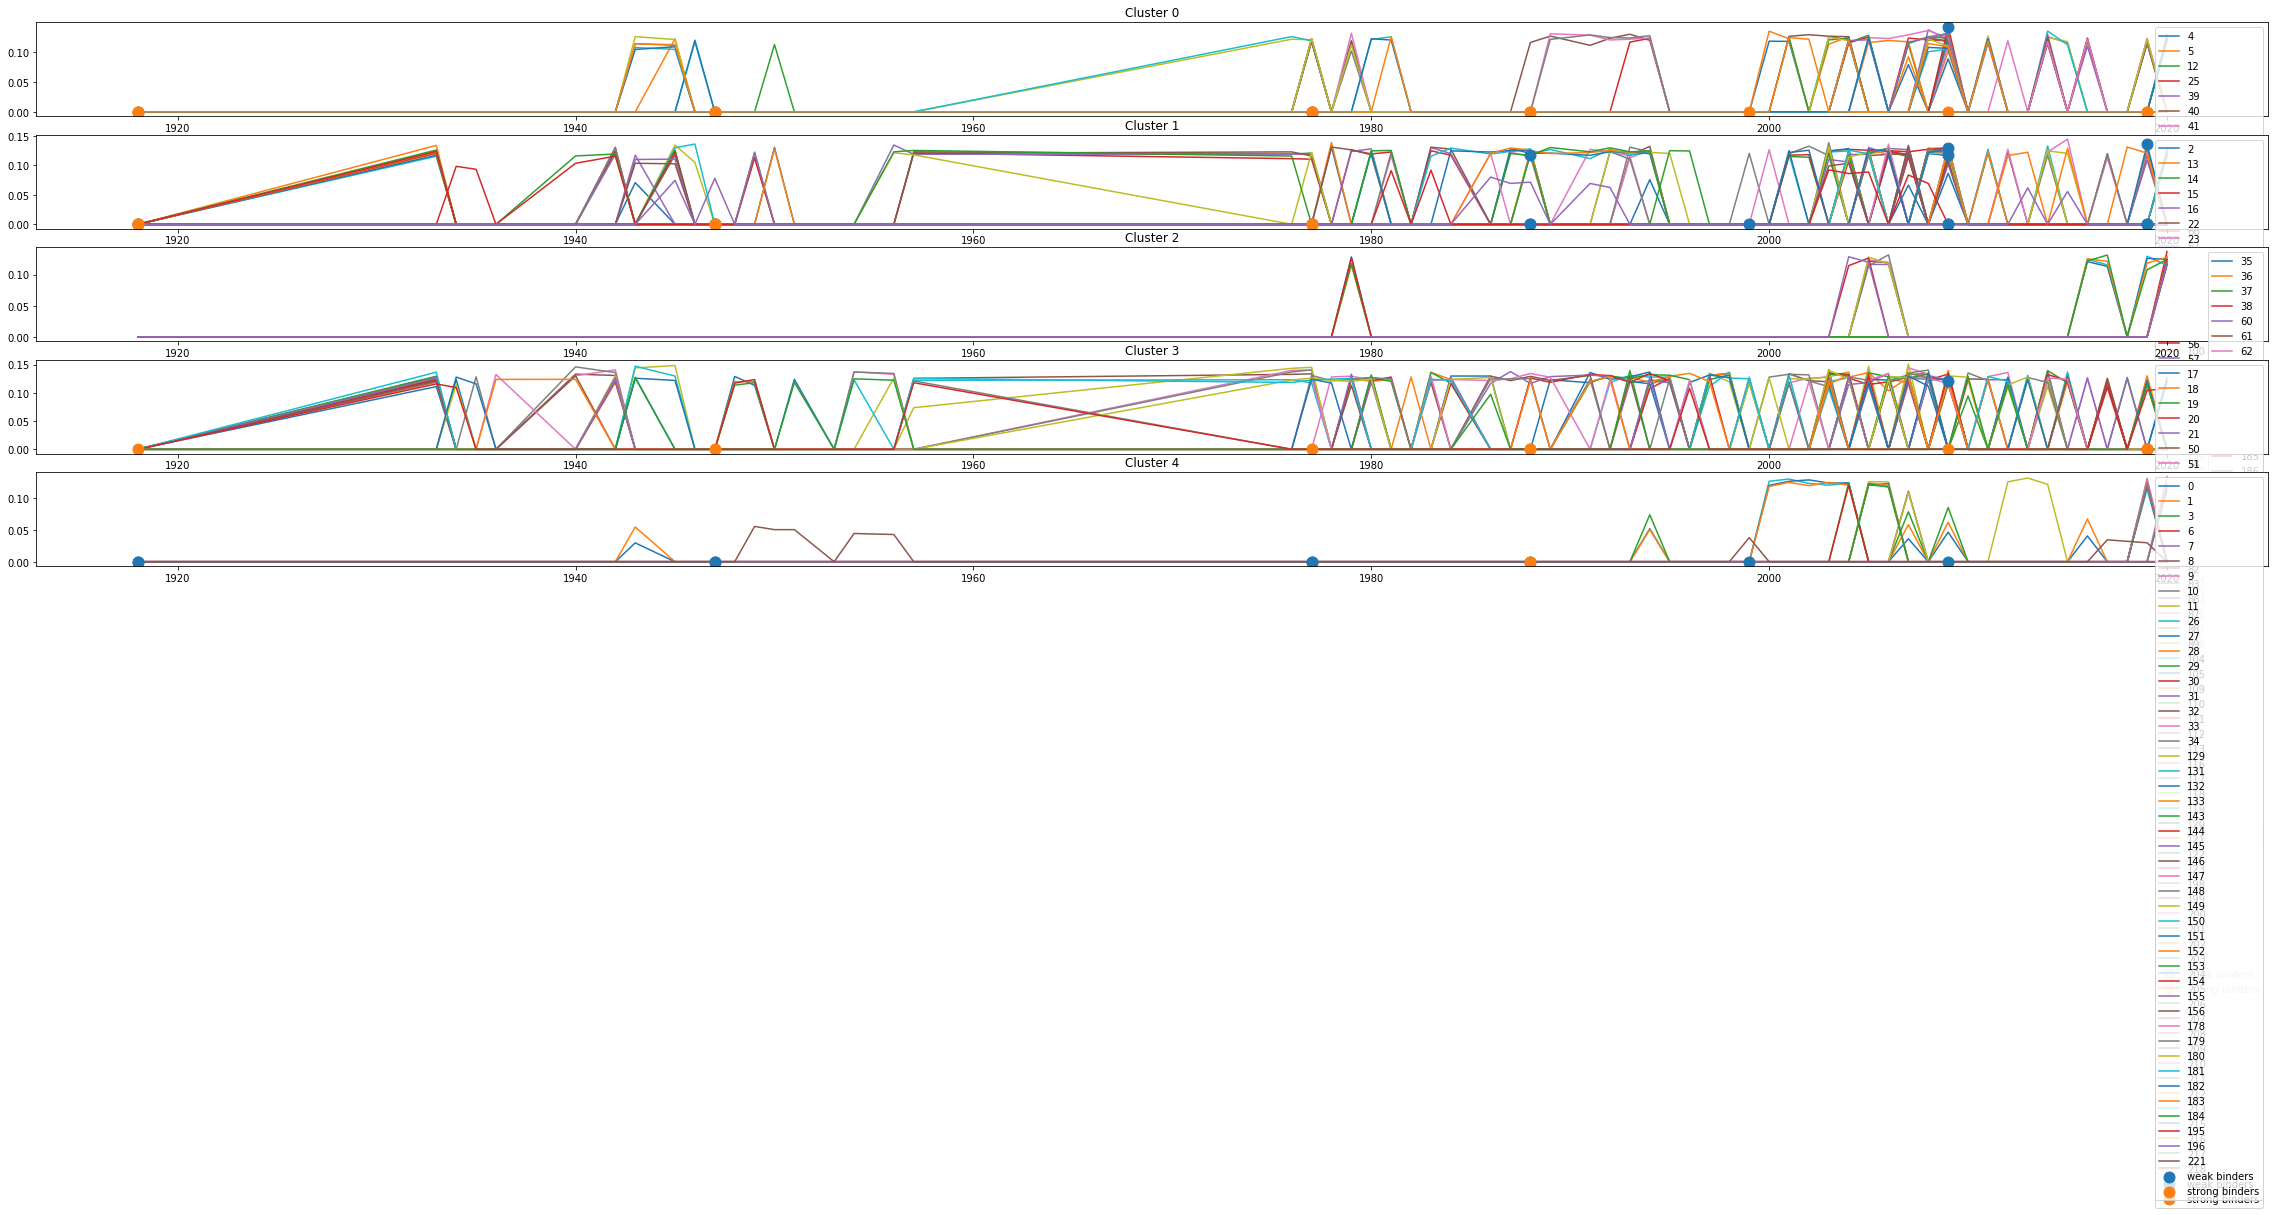

In [21]:
fig, axis = plt.subplots(num_clusters, 1, figsize=(40, 10))
for l in np.unique(labels):
    cols = df_labels[df_labels==l].index.to_list()
    df_plot = df_embedding_distance[cols].copy()
    weak_binders_pts = np.array([[k, i] for k in weak_binders_mask.keys() for i in df_plot.loc[k, weak_binders_mask[k]]])
    strong_binders_pts = np.array([[k, i] for k in strong_binders_mask.keys() for i in df_plot.loc[k, strong_binders_mask[k]]])
    df_plot.plot.line(zorder = 1, ax = axis[l])
    
    if len(weak_binders_pts):
        axis[l].scatter(weak_binders_pts[:, 0], weak_binders_pts[:, 1], s = 120, label = "weak binders", c = '#1f77b4', zorder = 2)
        print("\nCluster " + str(l) + " has " + str(weak_binders_pts.shape[0]) + " weak binders within " + str(df_plot.shape[0]) + " 9-mers.")
    else: 
        print("\nCluster " + str(l) + " doesn't have any weak binder within " + str(df_plot.shape[0]) + " 9-mers.")
        
    if len(strong_binders_pts):
        axis[l].scatter(strong_binders_pts[:, 0], strong_binders_pts[:, 1], s = 120, label = "strong binders", c = '#ff7f0e', zorder = 2)
        print("\nCluster " + str(l) + " has " + str(strong_binders_pts.shape[0]) + " strong binders within " + str(df_plot.shape[0]) + " 9-mers.")
    else: 
        print("\nCluster " + str(l) + " doesn't have any strong binder within " + str(df_plot.shape[0]) + " 9-mers.")
    
    axis[l].set_title('Cluster ' + str(l))
    axis[l].legend(loc='upper right')

In [22]:
# run 20 times the clustering
run = 20
list_run = []
for r in range(run):
    num_clusters = 5
    km = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", n_init = 20)
    # km = KernelKMeans(n_clusters=num_clusters, n_init=20)
    labels = km.fit_predict(time_series_dataset)
    df_labels = pd.Series(labels, index = df_embedding_distance.columns.to_list())
    list_df_9_mer = []
    for l in np.unique(labels):
        cols = df_labels[df_labels==l].index.to_list()
        df_9_mer = df_selected_year_sequence[cols].copy()
        weak_binders_9_mer = [str(k)+ " " +str(i) for k in weak_binders_mask.keys() for i in df_9_mer.loc[k, weak_binders_mask[k]]]

        if len(weak_binders_9_mer):
            list_df_9_mer.append(weak_binders_9_mer)
        
    list_run += list_df_9_mer

In [23]:
# get the intersections
list_to_merge = list_run.copy()
while True:
    list_merge = []
    for i in range(len(list_to_merge)):
        list_merge += [list(filter(lambda x: x in list_to_merge[i], sublist)) for sublist in list_to_merge[i+1:]]

    # remove the empty sublists
    list_merge = [x for x in list_merge if x] 
    
    # stop the loop when we cannot merge anymore
    if len(list_merge) == 0:
        break
    
    # remove the duplicates and reset list_to_merge value
    list_to_merge = []
    for i in list_merge:
        if i not in list_to_merge:
            list_to_merge.append(i)
    
list_to_merge

[['1988 FMLMPRQKI', '2009 FMLMPRQKI', '2019 FMLMPRQKI'],
 ['1918 TLGLDIETA',
  '1947 TLGLNIETA',
  '1977 TLGLNIETA',
  '1988 TLGLNIETA',
  '1999 TLGLNIETA',
  '2009 TLGLDIETA',
  '2019 TLGLDIKTA'],
 ['1918 MLMPKQKVA',
  '1947 MLMPKQKVA',
  '1977 MLMPKQKVA',
  '2009 MLMPRQKII',
  '2019 MLMPRQKII'],
 ['1988 TLKMNIASV', '2009 TLRMTIASV']]

In [24]:
# create dict binders
test_binders = []
for list_binders in list_to_merge:
    dict_binders = {}
    for binder in list_binders:
        year, nine_mer = binder.split(" ")
        dict_binders[int(year)] = nine_mer
    test_binders.append(dict_binders)

# create masks to identify binders later 
test_binders_mask = []
for dict_binder in test_binders:
    dict_mask = {}
    for y in dict_binder.keys():
        dict_mask[y] = df_selected_year_sequence.loc[y].isin([dict_binder[y]])
    test_binders_mask.append(dict_mask)


Cluster 2 has 3 binders:
{1988: 'FMLMPRQKI', 2009: 'FMLMPRQKI', 2019: 'FMLMPRQKI'}

Cluster 2 has 7 binders:
{1918: 'TLGLDIETA', 1947: 'TLGLNIETA', 1977: 'TLGLNIETA', 1988: 'TLGLNIETA', 1999: 'TLGLNIETA', 2009: 'TLGLDIETA', 2019: 'TLGLDIKTA'}

Cluster 2 has 2 binders:
{1988: 'TLKMNIASV', 2009: 'TLRMTIASV'}

Cluster 4 has 5 binders:
{1918: 'MLMPKQKVA', 1947: 'MLMPKQKVA', 1977: 'MLMPKQKVA', 2009: 'MLMPRQKII', 2019: 'MLMPRQKII'}


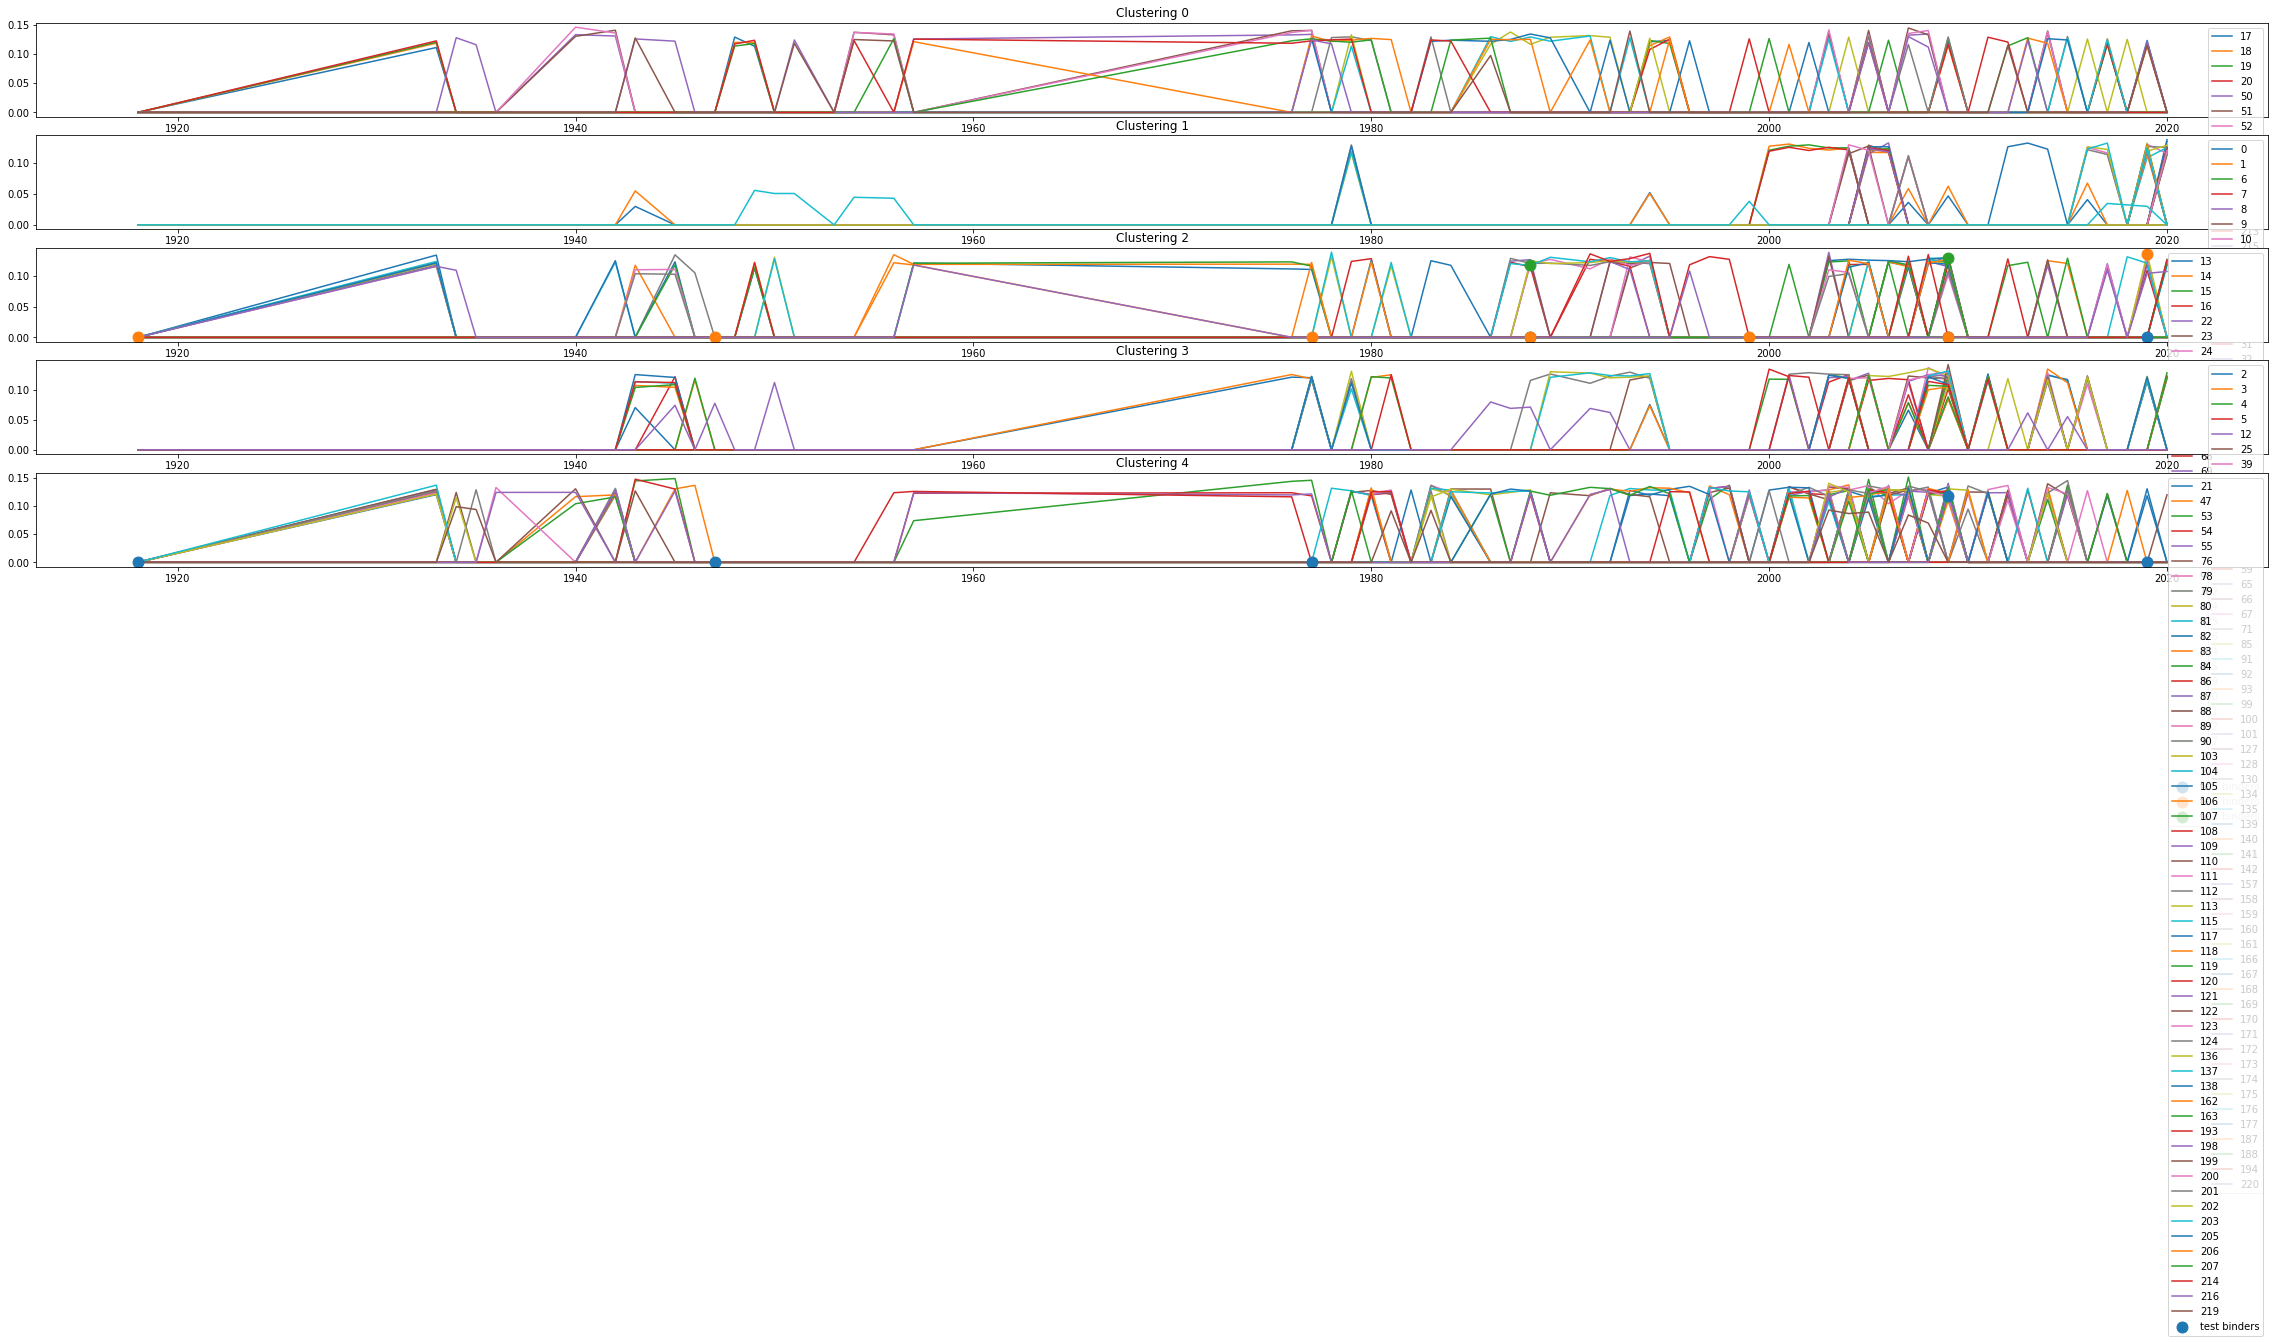

In [25]:
# run the K means clustering
num_clusters = 5
km = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
labels = km.fit_predict(time_series_dataset)
df_labels = pd.Series(labels, index = df_embedding_distance.columns.to_list())

# plot the clustering result along with binders
fig, axis = plt.subplots(num_clusters, 1, figsize=(40, 10))
for l in np.unique(labels):
    cols = df_labels[df_labels==l].index.to_list()
    df_plot = df_embedding_distance[cols].copy()
    df_epitopes = df_selected_year_sequence[cols].copy()
    df_plot.plot.line(zorder = 1, ax = axis[l])
    
    for mask in test_binders_mask:

        binders_pts = np.array([[k, i] for k in mask.keys() for i in df_plot.loc[k, mask[k]]])
        binders_epitopes = dict([(k, i) for k in mask.keys() for i in df_epitopes.loc[k, mask[k]]])

        if len(binders_pts):
            axis[l].scatter(binders_pts[:, 0], binders_pts[:, 1], s = 120, label = "test binders", zorder = 2)
            print("\nCluster " + str(l) + " has " + str(binders_pts.shape[0]) + " binders:")
            print(binders_epitopes)
    
        
    axis[l].set_title('Clustering ' + str(l))
    axis[l].legend(loc='upper right')